#In questo notebook si allena nuovamente la rete che prende in input l'immagine e le feature con pyradiomics, ma in aggiunta si utilizza un dataset molto ampio di immagini DICOM le cui dimensioni delle singole immagini sono molto grandi. Dopo aver preparato i dati grazie ai codici allegati, si adottano strategie per non esaurire la ram disponibile. Per il fatto che colab hai dei limiti sulla memoria allocabile durante il training, le immagini vengono anche riscalate nel generatore.

Carichiamo i dati dal drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Helper functions

In [2]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 66kB/s 


In [3]:
!pip install pyradiomics

     |████████████████████████████████| 163kB 4.3MB/s 
     |████████████████████████████████| 112kB 7.2MB/s 
     |████████████████████████████████| 552kB 7.4MB/s 


In [47]:
"""docstring"""
import glob
import logging
import os
import re
import time
import warnings
import pickle
import SimpleITK as sitk
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.python.keras import backend as K  # pylint: disable=E0611
from skimage.filters import threshold_multiotsu
import matplotlib.pyplot as plt
from PIL import Image
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(levelname)s:%(name)s:%(message)s")

file_handler = logging.FileHandler("CAE_functions.log")
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)


def save_newext(file_name, data_path, ext1, ext2, endpath):
    """Riscrive le immagini in formato leggibile per pyradiomics
    :type file_name: str
    :param file_path: nome del file della immagine

    :type data_path: str
    :param data_path: percorso della cartella dove si trova la immagine

    :type ext1: str
    :param ext1: stringa identificativa dell'estenzione di partenza della immagine

    :type ext2: str
    :param ext2: stringa identificativa dell'estenzione finale della immagine

    :type endpath: str
    :param endpath: percorso della cartella di arrivo
    :returns: dopo aver salvato il nuovo file, restituisce l'esito
    :rtype: bool


    """

    if ext1 == ext2:
        logger.debug(
            "il file %s in %s ha già la estenzione %s", file_name, data_path, ext2
        )
    try:
        image = plt.imread(os.path.join(data_path, file_name))
        file_name = file_name.replace(
            f".{ext1}", f".{ext2}"
        )
        logger.info(
            "read %s and changed extension from %s to%s",
            os.path.join(data_path, file_name),
            ext1,
            ext2,
        )
    except Exception as e_error:
        raise Exception("immagine o path non trovati") from e_error
    status = cv2.imwrite(                       # pylint: disable=E1101
        os.path.join(endpath, file_name), image
    )
    logger.info("ho scritto il file %s in %s come .%s ", file_name, endpath, ext2)
    return status


def unit_masks(file_name, data_path, ext1, ext2, endpath):
    """Normalizza i valori dei pixel delle maschere.
    Permette  di cambiare l'estenzione.

    :type file_name: str
    :param file_path: nome del file della maschera

    :type data_path: str
    :param data_path: percorso della cartella dove si trova la maschera

    :type ext1: str
    :param ext1: stringa identificativa dell'estenzione di partenza della maschera

    :type ext2: str
    :param ext2: stringa identificativa dell'estenzione finale della maschera

    :type endpath: str
    :param endpath: percorso della cartella di arrivo

    :returns: dopo aver salvato il nuovo file, restituisce l'esito e l'immagine
    :rtype: bool, array

    """

    try:
        image = plt.imread(os.path.join(data_path, file_name))
        logger.info("Ho letto %s in %s", file_name, data_path)
    except Exception as e_error:
        raise Exception("immagine o path non trovati!") from e_error

    image = image / 255
    file_name = file_name.replace(f".{ext1}", f".{ext2}")
    status = cv2.imwrite(                       # pylint: disable=E1101
        os.path.join(endpath, file_name), image
    )
    logging.info("ho scritto %s in %s con successo", file_name, endpath)
    return status, image


def read_dataset(        # pylint: disable=R0913
    dataset_path, ext, benign_label, malign_label, x_id="_resized", y_id="_mass_mask"
):
    """Data la cartella con le maschere e le immagini, restituisce i vettori con le immagini,
    le maschere e le classi. Restituisce i vettori come tensori da dare alla rete.

    :type dataset_path: str
    :param dataset_path: Cartella con le immagini e le relative maschere

    :type data_path: str
    :param data_path: percorso della cartella dove si trova la maschera

    :type ext: str
    :param ext: stringa identificativa dell'estenzione delle immagini e maschere

    :type x_id: str
    :param x_id: identificativo delle immagini

    :type x_id: str
    :param x_id: identificativo delle maschere

    :type benign_label: str
    :param benign_label: identificativo delle masse benigne

    :type malign_label: str
    :param malign_label: identificativo delle masse maligne

    :returns: restituisce i vettori con le immagini, le maschere e le classi
    :rtype: array

    """

    fnames = glob.glob(os.path.join(dataset_path, f"*{x_id}.{ext}"))
    logger.info("ho analizzato %s cercando le immagini", dataset_path)
    if fnames == []:
        raise Exception(
            "Niente immagini! Il path è sbagliato, magari x_id o ext sono sbagliati! "
        )

    images_ = []
    masks_ = []
    class_labels = []
    for fname in fnames:
        images_.append(plt.imread(fname)[1:, 1:, np.newaxis])
        masks_.append(plt.imread(fname.replace(x_id, y_id))[1:, 1:, np.newaxis])
        if benign_label in fname:
            class_labels.append(0)
        elif malign_label in fname:
            class_labels.append(1)
    logger.info(
        "ho preso immagini e maschere da %s, ho creato gli array delle immagini, maschere e classi",
        dataset_path,
    )
    return np.array(images_), np.array(masks_), np.array(class_labels)


def read_dataset_big(
    dataset_path_mass, dataset_path_mask, benign_label, malign_label, ext="png"
):
    """Versione di read_dataset per il dataset del TCIA.
    Data la cartella con le maschere e le immagini,
    restituisce i vettori con i filepath delle immagini, le maschere e le classi.

    :type dataset_path_mass: str
    :param dataset_path_mass: Cartella con le immagini

    :type dataset_path_mask: str
    :param dataset_path_mask: percorso della cartella dove si trovano le maschera

    :type ext: str
    :param ext: stringa identificativa dell'estenzione delle immagini e maschere


    :returns: restituisce i vettori con i path delle immagini, le maschere e le classi
    :rtype: array



    """

    fnames = glob.glob(os.path.join(dataset_path_mass, f"*.{ext}"))
    logger.info("ho analizzato %s cercando le immagini", dataset_path_mass)

    if fnames == []:
        raise Exception(
            "Niente immagini! Il path è sbagliato, magari ext è sbagliato! "
        )

    masknames = glob.glob(os.path.join(dataset_path_mask, f"*.{ext}"))
    logger.info("ho analizzato %s cercando le maschere", dataset_path_mask)

    if masknames == []:
        raise Exception("Immagini o path non trovati!")
    fnames.sort()
    images_ = []
    masks_ = []
    class_labels = []
    for fname in fnames:
        try:
            assert fname.replace(dataset_path_mass, dataset_path_mask) in masknames
            logger.debug("sto verificando che %s sia in %s", fname, dataset_path_mask)
            masks_.append(fname.replace(dataset_path_mass, dataset_path_mask))
            images_.append(fname)

            if benign_label in fname:
                class_labels.append(0)
            elif malign_label in fname:
                class_labels.append(1)
        except:
            warnings.warn(
                f"{fname} non vi è corrispondenza in {dataset_path_mask},forse immagine mancante"
            )
            logger.warning(
                "%s non vi è corrispondenza in %s, possibile immagine mancante",
                fname,
                dataset_path_mask,
            )

    return np.array(images_), np.array(masks_), np.array(class_labels)


def radiomic_dooer(list_test, endpath, lab, extrc):

    """Funzione per estrarre le feature con pyradiomics e salvarle in un dizionario.

    :type list_test: list
    :param list_test: lista con path immagine e relativa maschera normalizzata
    :type endpath: str
    :param endpath: cartella dove si salva il pickle del dizionario
    :type lab: int
    :param lab: label per indicare la maschera, va da 1 a 255
    :extrc type: str
    :extr param: classe estrattore di pyradiomics

    :returns: dopo aver salvato il pickle, restituisce il tempo impiegato
    :rtype: str


    """

    extr_start = time.perf_counter()
    try:
        logger.debug(
            "sto cercando di estrarre le feature da %s utilizzando come maschera %s",
            list_test[0],
            list_test[1],
        )
        info = extrc.execute(list_test[0], list_test[1], lab)

    except Exception as e_error:
        raise Exception(
            "Pyradiomics: problema di label o path, o non c'è featureextractor"
        ) from e_error

    extr_end = time.perf_counter()
    logging.info("tempo di estrazione: %d", extr_end - extr_start)
    updt_start = time.perf_counter()
    pattern = re.compile(r"[M][\w-]*[0-9]*[\w]{13}")
    logging.debug("in regex il pattern è %s", pattern)
    name = re.findall(pattern, list_test[0])
    logging.debug("il patter che sto cercando è %s", name)

    dict_r = {name[0]: info}
    try:
        with open(os.path.join(endpath, f"feats_{name[0]}.pickle"), "wb") as handle:
            pickle.dump(dict_r, handle, protocol=pickle.HIGHEST_PROTOCOL)
            logging.info("salvato il pickle feats_%s.pickle in %s", name[0], endpath)
    except Exception as e_error:
        raise Exception("Controlla che %s sia giusto"%endpath) from e_error

    del dict_r
    updt_end = time.perf_counter()
    logger.info("time to update:%d", updt_end - updt_start)

    return "time to update:{updt_end-updt_start}"


def read_pgm_as_sitk(image_path):
    """Legge un .pgm come una immagine Simple ITK

    :type image_path: str
    :param image_path: path dell'immagine voluta
    :returns: restituisce l'immagine da far leggere a pyradiomics
    :rtype: array
    """
    try:
        np_array = np.asarray(Image.open(image_path))
    except Exception as e_error:
        raise Exception('impossibile leggere %s'%image_path) from e_error
    logger.info("sto leggendo %s", image_path)
    try:
        sitk_image = sitk.GetImageFromArray(np_array)
    except Exception as e_error:
        raise Exception('impossibile convertire %s in ITK'%image_path) from e_error
    logger.info("sto convertendo %s", image_path)

    return sitk_image


def dict_update_radiomics(data_path, dictionary):

    """Funzione per unire i vari dizionari creati con radiomic_dooer per poi creare il dataframe

    :type data_path: str
    :param data_path: percorso del pickle da aprire
    :type dictionary: dict
    :param dictionary: dizionario generale del dataframe
    :returns: restituisce il dizionario aggiornato
    :rtype: dict


    """

    with open(data_path, "rb") as handle:
        logger.info("ho aperto %s", data_path)
        pic_loaded = pickle.load(handle)
        logger.info("ho caricato %s", handle)
        dictionary.update(pic_loaded)
        logger.info("ho fatto un update a %s", dictionary)

    return dictionary


def blender(img1, img2, weight_1, weight_2):
    """Funzione per sovraimporre due immagini con sfumatura

    :type img1: array numpy
    :param img1: immagine da sovrapporre
    :type img2: array numpy
    :param img2: immagine da svrapporre
    :type weight_1: int or float
    :param weight_1: valore di sfumatura di img1
    :type weight_2: int or float
    :param weight_2: valore di sfumatura di img2
    :returns: restituisce l'immagine sovrapposta
    :rtype: array

    """

    try:
        image = cv2.addWeighted(                        # pylint: disable=E1101
            img1, weight_1, img2, weight_2, 0
        )
        logger.debug(
            "sto cercando di sovrapporre le immagini con pesi rispettivamente %d e %d",
            weight_1,
            weight_2,
        )
    except Exception as e_error:
        raise Exception(
            "Sovrapposizione non riuscita.Immagini o variabili d'ingresso non adeguate."
        ) from e_error

    logger.info("sovrapposizione riuscita")
    return image


def dice(pred, true, k=1):
    """Funzione per calcolare l'indice di Dice

    :type pred: array numpy
    :param pred: immagini predette dal modello
    :type true: array numpy
    :param true: immagini target
    :type k: int
    :param k: valore pixel true della maschera
    :returns: restituisce il valore di Dice
    :rtype: float


    """

    intersection = np.sum(pred[true == k]) * 2.0
    try:
        dice_value = intersection / (np.sum(pred) + np.sum(true))
    except ZeroDivisionError:
        logger.exception("provato a dividere per zero!")
    logger.info("calcolato correttamente il dice ottenendo %d", dice_value)
    return dice_value


def dice_vectorized(pred, true, k=1):
    """
    Versione vettorizzata per calcolare il coefficiente di dice

    :type pred: array numpy
    :param pred: immagini predette dal modello
    :type true: array numpy
    :param true: immagini target
    :type k: int
    :param k: valore pixel true della maschera
    :returns: restituisce il dice medio
    :rtype: float

    """

    intersection = 2.0 * np.sum(pred * (true == k), axis=(1, 2, 3))
    try:
        dice_value = intersection / (
            pred.sum(axis=(1, 2, 3)) + true.sum(axis=(1, 2, 3))
        )
    except ZeroDivisionError:
        logger.exception("provato a dividere per zero!")
    logger.info("calcolato correttamente il dice medio ottenendo %d", dice_value.mean())
    return dice_value


def modelviewer(model):
    """
    Funzione per visualizzare l'andamento della loss di training
     e validazione per l'autoencoder e per il classificatore
    :type model: str
    :param model: history del modello di Keras ottenuto dalla funzione

    """

    plt.figure("modelviewer")
    plt.subplot(2, 1, 1)
    plt.title("autoencoder")
    try:
        plt.plot(model.history["decoder_output_loss"])
        plt.plot(model.history["val_decoder_output_loss"])
    except Exception as e_error:
        raise Exception(
            "Model non ha i campi decoder_output_loss o val_decoder_output_loss"
        ) from e_error

    plt.legend(["loss", "val_loss"])
    plt.subplot(2, 1, 2)
    plt.title("classifier")
    try:
        plt.plot(model.history["classification_output_loss"])
        plt.plot(model.history["val_classification_output_loss"])
    except Exception as e_error:
        raise Exception(
            "Model non ha i campi classification_output_loss o val_classification_output_loss"
        ) from e_error

    plt.legend(["loss", "val_loss"])
    plt.show()


def heatmap(input_image, model,show=True):
    """
    Funzione che mostra la heatmap dell'ultimo layer convoluzionale
    prima del classificatore senza funzionalità radiomiche

    :type input_image: array numpy
    :param input_image: immagine da segmentare

    :type model: str
    :param model: modello allenato
    :returns: Plotta la heatmap sovrapposta e l'immagine, restituisce la heatmap
    :rtype: array


    """

    img_tensor = input_image[np.newaxis, ...]
    preds = model.predict(img_tensor)[1]
    argmax = np.argmax(preds)
    conv_layer = model.get_layer("last_conv")
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[1][:, np.argmax(predictions[1])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heat_map = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heat_map = np.maximum(heat_map, 0)
    max_heat = np.max(heat_map)
    if max_heat == 0:
        max_heat = 1e-10
    heat_map /= max_heat

    if show:
        input_image = np.asarray(255 * input_image, np.uint8)
        heat_map = np.asarray(255 * heat_map.squeeze(), np.uint8)

        heat_map_res = cv2.resize(                      # pylint: disable=E1101
            heat_map, (input_image.shape[1], input_image.shape[0])
        )

        plt.figure("Heatactivation")
        plt.subplot(1,3,1)
        plt.imshow(input_image)
        plt.title('image')
        plt.subplot(1,3,2)
        plt.imshow(heat_map)
        plt.title('heatmap')
        plt.subplot(1,3,3)
        plt.imshow(blender(input_image, heat_map_res, 1, 1))
        if argmax == 1:
            plt.title("the mass is malign")
        else:
            plt.title("the mass is benign")
        plt.show()
    return heat_map


def heatmap_rad(input_image, feature, model,show=True):
    """
    Funzione che mostra la heatmap dell'ultimo layer convoluzionale
    prima del classificatore con funzionalità radiomiche

    :type input_image: array numpy
    :param input_image: immagine da segmentare
    :type feature: array numpy
    :param feature: feature estratte con pyradiomics
    :type model: class
    :param model: modello allenato
    :returns: Plotta la heatmap sovrapposta e l'immagine, restituisce la heatmap
    :rtype: array
    """

    img_tensor = input_image[np.newaxis, ...]
    feature_tensor = feature[np.newaxis, ...]
    preds = model.predict([img_tensor, feature_tensor])[1]
    argmax = np.argmax(preds)
    conv_layer = model.get_layer("last_conv")
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model([img_tensor, feature_tensor])
        loss = predictions[1][:, np.argmax(predictions[1])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heat_map = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heat_map = np.maximum(heat_map, 0)
    max_heat = np.max(heat_map)
    if max_heat == 0:
        max_heat = 1e-10
    heat_map /= max_heat
    if show:
        input_image = np.asarray(255 * input_image, np.uint8)
        heat_map = np.asarray(255 * heat_map.squeeze(), np.uint8)

        heat_map_res = cv2.resize(                      # pylint: disable=E1101
            heat_map, (input_image.shape[1], input_image.shape[0])
        )

        plt.figure("Heatactivation")
        plt.subplot(1,3,1)
        plt.imshow(input_image)
        plt.title('image')
        plt.subplot(1,3,2)
        plt.imshow(heat_map)
        plt.title('heatmap')
        plt.subplot(1,3,3)
        plt.imshow(blender(input_image, heat_map_res, 1, 1))
        if argmax == 1:
            plt.title("the mass is malign")
        else:
            plt.title("the mass is benign")
        plt.show()
    return heat_map


def plot_roc_curve(fper, tper, auc):
    """Funzione che fa il plot della curva roc

    :type fper: float
    :param fper: percentuale falsi positivi

    :type tper: float
    :param tper: percentuale veri positivi

    """

    plt.figure("AUC")
    plt.plot(fper, tper, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve with AUC = %.2f" % auc)
    plt.legend()
    plt.show()


def otsu(image, n_items=2):
    """Funzione che implementa l'algoritmo di Otsu per la segmentazione

    :type image: numpy array
    :param fper: immagine da segmentare
    :type n_items: int
    :param n_items: numero di oggetti da segmentare nell'immagine
    :returns: restituisce l'immagine binarizzata
    :rtype: array

    """

    thresholds = threshold_multiotsu(image, classes=n_items)
    regions = np.digitize(image, bins=thresholds)
    return regions


# Import


In [48]:


import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from skimage.transform import resize
from skimage.io import imread

datapath='/content/drive/MyDrive'
maindir='Test2'
mass_train='Train_data'
mass_test='Test_data'
mask_train='Train_data_masks'
mask_test='Test_data_masks'
mask_train_res='resized_masks'
benign_label='BENIGN'
malign_label='MALIGNANT'
features_path='feats'

path_mass_tr=os.path.join(datapath,maindir,mass_train)
path_masks_resized=os.path.join(datapath,maindir,mask_train_res)




X_big_train,Y_big_train,Class_big_train=read_dataset_big(path_mass_tr
    ,path_masks_resized,benign_label,malign_label)





In [49]:
X_big_train

array(['/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_00001_LEFT_CC_MALIGNANT_1.png',
       '/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_00001_LEFT_MLO_MALIGNANT_1.png',
       '/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_00004_LEFT_CC_BENIGN_1.png',
       ...,
       '/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_02079_RIGHT_MLO_MALIGNANT_1.png',
       '/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_02092_LEFT_CC_MALIGNANT_1.png',
       '/content/drive/MyDrive/Test2/Train_data/Mass-Training_P_02092_LEFT_MLO_MALIGNANT_1.png'],
      dtype='<U101')

#Carichiamo le features dal .csv

In [50]:
import pandas as pd

Pandatabigframe=pd.read_csv('/content/drive/MyDrive/Test2/Bigframe_test.csv')
#Pandata_big=pd.DataFrame(dataframe_big_train)

In [51]:
Pandatabigframe

,Unnamed: 0,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,Mass-Training_P_00009_RIGHT_MLO_MALIGNANT_1,0.747413,226.830157,240.709368,29284.5,169.535902,1192.170706,0.040710,29291.0,0.508845,9.411265,22695.040763,0.774813,0.135460,73.500427,16707.670395,163035.454850,1.427230,234579.983271,0.000107,0.000099,0.902852,146902.986886,0.000098,164272.034469,1.211831e+10,-1.276736e+07,64761.473513,626.826605,0.980811,19.657529,5.682069,235.179968,0.112117,0.051497,0.998607,0.971935,-0.346504,0.998891,0.053087,...,4.138706e+13,0.002509,1.044279e+07,72.132504,0.002505,16727.584700,162969.283451,1.052872,171813.231332,0.000102,0.000101,8.974453,27829.396127,0.966595,0.982930,0.017829,0.987207,160841.620990,0.000101,68.130425,0.002493,16794.473659,162765.336237,1.230220,201420.171924,0.000109,0.000105,23972.682207,0.877285,0.950186,154533.123875,0.000104,9.218375,0.932915,0.081230,0.003469,0.001150,1.895985e+06,1.061533,182.963476
1,Mass-Training_P_00015_LEFT_MLO_MALIGNANT_1,0.879908,244.257980,258.443417,40480.5,214.924671,1196.462120,0.029557,40488.0,0.596113,9.168308,32538.787888,0.803665,0.118911,125.602104,11446.811443,142006.697244,1.366430,195327.274303,0.000041,0.000037,0.916936,129947.331107,0.000036,142489.029616,8.745047e+09,2.186827e+06,44107.005955,948.254535,0.957894,24.262830,5.987544,353.664133,0.096540,0.042444,0.998789,

In [52]:
Pandatabigframe.sort_values(by='Unnamed: 0')

,Unnamed: 0,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
5,Mass-Training_P_00001_LEFT_CC_MALIGNANT_1,0.844456,438.527378,490.407993,120549.5,370.316873,3131.243000,0.025975,120561.0,0.393071,9.989785,97158.095412,0.805883,0.114843,189.830716,40739.724257,341696.582377,1.357097,468384.439976,0.000021,0.000019,0.918042,312773.291555,0.000018,342786.096581,5.005489e+10,-8.991204e+06,161279.939512,987.126563,0.987831,24.722411,6.015083,369.627113,0.094996,0.041401,0.999240,0.979004,-0.317632,0.998761,0.041726,...,1.628247e+14,0.001575,2.546217e+07,186.395482,0.001569,40747.020535,341518.601797,1.044101,357123.539733,0.000019,0.000019,9.591650,115489.344993,0.971844,0.985679,0.014822,0.989254,337714.161169,0.000019,176.482603,0.001551,40772.596380,341017.455498,1.189012,407890.571660,0.000021,0.000019,101911.656454,0.895683,0.958174,326280.793304,0.000019,9.811736,0.943763,0.066285,0.005103,0.000335,7.022677e+06,1.233332,141.196750
11,Mass-Training_P_00001_LEFT_MLO_MALIGNANT_1,0.948494,215.372212,255.313533,32195.0,204.279200,1208.722005,0.037544,32198.0,0.526227,9.350704,25298.681533,0.785722,0.130659,88.825766,16441.021103,202198.487235,1.406174,286928.205789,0.000044,0.000041,0.908237,182939.830030,0.000040,203168.790075,1.189493e+10,-1.125244e+07,63816.407375,785.673864,0.975660,22.071072,5.851098,293.085514,0.103679,0.046720,0.

In [53]:
Pandatabigframe.iloc[:,1:]

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.747413,226.830157,240.709368,29284.5,169.535902,1192.170706,0.040710,29291.0,0.508845,9.411265,22695.040763,0.774813,0.135460,73.500427,16707.670395,163035.454850,1.427230,234579.983271,0.000107,0.000099,0.902852,146902.986886,0.000098,164272.034469,1.211831e+10,-1.276736e+07,64761.473513,626.826605,0.980811,19.657529,5.682069,235.179968,0.112117,0.051497,0.998607,0.971935,-0.346504,0.998891,0.053087,385.017115,...,4.138706e+13,0.002509,1.044279e+07,72.132504,0.002505,16727.584700,162969.283451,1.052872,171813.231332,0.000102,0.000101,8.974453,27829.396127,0.966595,0.982930,0.017829,0.987207,160841.620990,0.000101,68.130425,0.002493,16794.473659,162765.336237,1.230220,201420.171924,0.000109,0.000105,23972.682207,0.877285,0.950186,154533.123875,0.000104,9.218375,0.932915,0.081230,0.003469,0.001150,1.895985e+06,1.061533,182.963476
1,0.879908,244.257980,258.443417,40480.5,214.924671,1196.462120,0.029557,40488.0,0.596113,9.168308,32538.787888,0.803665,0.118911,125.602104,11446.811443,142006.697244,1.366430,195327.274303,0.000041,0.000037,0.916936,129947.331107,0.000036,142489.029616,8.745047e+09,2.186827e+06,44107.005955,948.254535,0.957894,24.262830,5.987544,353.664133,0.096540,0.042444,0.998789,0.973673,-0.290023,0.996652,0.042950,362.903991,...,5.958876

In [54]:
Pandatabigframe=Pandatabigframe.iloc[:,1:]

In [55]:
X_train_rad_big, X_test_rad_big, Y_train_rad_big, Y_test_rad_big,class_train_rad_big,class_test_rad_big,feature_train_big,feature_test_big = train_test_split(X_big_train, Y_big_train,Class_big_train,Pandatabigframe, test_size=0.2, random_state=42)

Ora che abbiamo tutte le feature, facciamo la pca

In [56]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
feature_train_bigg = sc.fit_transform(feature_train_big)
feature_test_bigg = sc.transform(feature_test_big)

In [57]:
from sklearn.decomposition import PCA

pca = PCA()
feature_train_bigg = pca.fit_transform(feature_train_bigg)
feature_test_bigg = pca.transform(feature_test_bigg)
explained_variance_big = pca.explained_variance_ratio_


In [58]:
explained_variance_big

array([3.00424455e-01, 1.73479278e-01, 1.46650565e-01, 8.37611837e-02,
       6.05313406e-02, 4.20098585e-02, 4.03259492e-02, 2.92882671e-02,
       2.12383312e-02, 1.53545481e-02, 1.38667318e-02, 1.26923740e-02,
       1.04200553e-02, 8.71181141e-03, 6.26435352e-03, 5.72150735e-03,
       4.18571022e-03, 3.67298572e-03, 2.73872137e-03, 2.37850348e-03,
       2.17610882e-03, 1.94902424e-03, 1.61191121e-03, 1.27838479e-03,
       1.21802294e-03, 1.10199417e-03, 1.00005921e-03, 8.17870009e-04,
       6.76354335e-04, 5.77840462e-04, 4.98064161e-04, 4.83244609e-04,
       4.20925000e-04, 3.50653979e-04, 3.32586019e-04, 2.88426398e-04,
       2.59072639e-04, 2.06964667e-04, 1.77978288e-04, 1.62911804e-04,
       1.40763474e-04, 1.33721225e-04, 9.51080946e-05, 7.33134803e-05,
       4.26229669e-05, 3.44171231e-05, 3.11507970e-05, 2.62522097e-05,
       2.50457285e-05, 1.65197451e-05, 1.32331966e-05, 1.13073390e-05,
       1.02198709e-05, 7.98731115e-06, 6.23016051e-06, 5.19346780e-06,
      

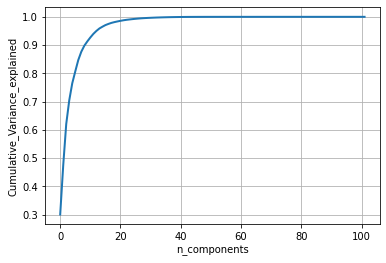

In [59]:
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot spettro dell pca   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

In [60]:
exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)  
for index,var in enumerate(exp_var_cumsum):  
    print('if n_components= %d,   variance=%f' %(index,np.round(var,3)))

if n_components= 0,   variance=30.040000
if n_components= 1,   variance=47.390000
if n_components= 2,   variance=62.060000
if n_components= 3,   variance=70.430000
if n_components= 4,   variance=76.480000
if n_components= 5,   variance=80.690000
if n_components= 6,   variance=84.720000
if n_components= 7,   variance=87.650000
if n_components= 8,   variance=89.770000
if n_components= 9,   variance=91.310000
if n_components= 10,   variance=92.690000
if n_components= 11,   variance=93.960000
if n_components= 12,   variance=95.000000
if n_components= 13,   variance=95.880000
if n_components= 14,   variance=96.500000
if n_components= 15,   variance=97.070000
if n_components= 16,   variance=97.490000
if n_components= 17,   variance=97.860000
if n_components= 18,   variance=98.130000
if n_components= 19,   variance=98.370000
if n_components= 20,   variance=98.590000
if n_components= 21,   variance=98.780000
if n_components= 22,   variance=98.950000
if n_components= 23,   variance=99.070000
if

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
feature_train_bigg = pca.fit_transform(feature_train_bigg)
feature_test_bigg = pca.transform(feature_test_bigg)

In [62]:
df_comp = pd.DataFrame(feature_train_bigg)

In [63]:
df_comp=df_comp.rename(columns={0: "Prima componente principale",1: "Seconda componente principale",2:"Terza componente principale"})

In [64]:
color_array=[]
for _,item in enumerate(class_train_rad_big):
  if item == 0:
    color_array.append("Benign")
  elif item == 1:
    color_array.append("Malignant")
  else:
    raise Exception(f"classe ha un valore sbagliato {item}")

In [65]:
!pip install plotly

In [66]:
import plotly.express as px
fig = px.scatter_3d(df_comp, x="Prima componente principale", y="Seconda componente principale", z="Terza componente principale", 
              title="Cluster dataset dopo PCA",color=color_array)
fig.show()

#Qui si fa la data augmentation con la nuova classe generatore che stavolta legge i path e carica le immagini batch per batch sul momento ogni epoca per risparmiare la ram

In [67]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [68]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip= True,
        fill_mode='reflect')

In [69]:
import keras
class MassesSequenceRadiomicsBig(keras.utils.Sequence):  # pylint: disable=R0902
    """ Classe per data augmentation per CAE con grande dataset """

    def __init__(  # pylint: disable=R0913
        self,
        images,
        masks,
        label_array,
        features,
        img_gen,
        batch_size=10,
        shape=(1024, 768),
        shape_tensor=(1024, 768, 1),
    ):
        """Inizializza la sequenza

        Parametri:

        images (np.array): path delle immagini
        masks (np.array): path delle maschere
        label_array (np.array): label di classificazione
        features (np.array): array di feature dopo la pca
        batch_size (int): dimensione della batch
        img_gen (ImageDatagenerator): Una istanza della classe ImageDatagenerator
        shape (tuple): shape dell'immagine.

        """
        self.images, self.masks, self.label_array, self.features = (
            images,
            masks,
            label_array,
            features,
        )
        self.shape = shape
        self.shape_tensor = shape_tensor
        self.img_gen = img_gen
        self.batch_size = batch_size

    def __len__(self):
        """restituisce il rapporto tra la lunghezza del vettore delle immagini
        e la dimensione della batch
        """
        return len(self.images) // self.batch_size

    def on_epoch_end(self):
        """Mischia il dataset a fine epoca."""
        self.images, self.masks, self.label_array, self.features = shuffle(
            self.images, self.masks, self.label_array, self.features
        )

    def process(self, img, transform):
        """ Applica una trasformazione random all'immagine"""
        img = self.img_gen.apply_transform(img, transform)
        return img

    def __getitem__(self, idx):  # pylint: disable=R0914
        """Organizza le immagini,maschere, classi e feature in batch"""
        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_masks = self.masks[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_label_array = self.label_array[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_features = self.features[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]

        images_list = []
        masks_list = []
        classes_ = []
        features_ = []

        for image, mask, label, feature in zip(
            batch_images, batch_masks, batch_label_array, batch_features
        ):
            transform = self.img_gen.get_random_transform(self.shape)
            images_el = resize(imread(str(image)), self.shape_tensor)
            masks_el = resize(imread(str(mask)), self.shape_tensor)
            images_list.append(self.process(images_el, transform))
            del images_el
            masks_list.append(self.process(masks_el, transform))
            del masks_el
            classes_.append(label)
            features_.append(feature)

        return [np.array(images_list) / 255, np.asarray(features_, np.float64)], [
            np.array(masks_list) / 255,
            np.asarray(classes_, np.float),
        ]

In [70]:
X_train_rad_big_tr, X_train_rad_big_val, Y_train_rad_big_tr, Y_train_rad_big_val,class_train_rad_big_tr,class_train_rad_big_val,feature_train_big_tr,feature_train_big_val = train_test_split(X_train_rad_big, Y_train_rad_big, to_categorical(class_train_rad_big, 2),feature_train_bigg, test_size=0.2, random_state=42)

In [71]:
mass_gen_rad_big = MassesSequenceRadiomicsBig(X_train_rad_big_tr, Y_train_rad_big_tr,class_train_rad_big_tr,feature_train_big_tr, train_datagen)

In [72]:
batch=mass_gen_rad_big[0]

In [73]:
len(mass_gen_rad_big)

84

In [74]:
batch

([array([[[[0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00],
           ...,
           [0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00]],
  
          [[0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00],
           ...,
           [0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00]],
  
          [[0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00],
           ...,
           [0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00]],
  
          ...,
  
          [[3.91579195e-03],
           [3.92154756e-03],
           [3.92156863e-03],
           ...,
           [0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00]],
  
          [[3.91722182e-03],
           [3.92155341e-03],
           [3.92156863e-03],
           ...,
           [0.00000000e+00],
           [0.00000000e+00],
           [0.00000000e+00]],
  
          [[

In [75]:
batch[0][0].shape

(10, 1024, 768, 1)

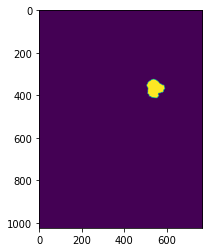

In [76]:
plt.imshow(batch[1][0][1].squeeze())

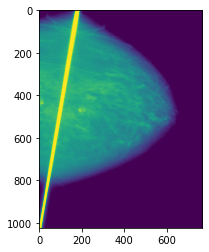

In [77]:
plt.imshow(batch[0][0][0].squeeze())

Stavolta ci serve anche un generatore per i dati di validazione

In [78]:
class ValidatorGenerator(keras.utils.Sequence):
    """Classe per generare i dati di validazione in batch per il dataset grande"""

    def __init__(  # pylint: disable=R0913
        self,
        images,
        masks,
        label_array,
        features,
        batch_size=10,
        shape=(1024, 768),
        shape_tensor=(1024, 768, 1),
    ):
        """Inizializza la sequenza

        Parametri:

        images (np.array): path delle immagini
        masks (np.array): path delle maschere
        label_array (np.array): label di classificazione
        features (np.array): array di feature dopo la pca
        batch_size (int): dimensione della batch
        img_gen (ImageDatagenerator): Una istanza della classe ImageDatagenerator
        shape (tuple): shape dell'immagine.

        """
        self.images, self.masks, self.label_array, self.features = (
            images,
            masks,
            label_array,
            features,
        )
        self.shape = shape
        self.batch_size = batch_size
        self.shape_tensor = shape_tensor

    def __len__(self):
        """restituisce il rapporto tra la lunghezza del vettore delle immagini
        e la dimensione della batch
        """
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):  # pylint: disable=R0914
        """Organizza le immagini,maschere, classi e feature di validazione in batch"""

        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_masks = self.masks[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_label_array = self.label_array[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_features = self.features[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]

        images_list = []
        masks_list = []
        classes_ = []
        features_ = []

        for image, mask, label, feature in zip(
            batch_images, batch_masks, batch_label_array, batch_features
        ):

            images_el = resize(imread(str(image)), self.shape_tensor)
            masks_el = resize(imread(str(mask)), self.shape_tensor)
            images_list.append(images_el)
            del images_el
            masks_list.append(masks_el)
            del masks_el
            classes_.append(label)
            features_.append(feature)

        return [np.array(images_list) / 255, np.asarray(features_, np.float64)], [
            np.array(masks_list) / 255,
            np.asarray(classes_, np.float),
        ]


In [79]:
Validation_data=ValidatorGenerator(X_train_rad_big_val, Y_train_rad_big_val,class_train_rad_big_val,feature_train_big_val)

In [80]:
batch_2=Validation_data[0]

In [81]:
batch[0][0].shape[1:]

(1024, 768, 1)

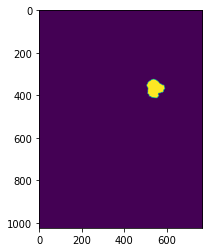

In [82]:
plt.imshow(batch[1][0][1].squeeze())

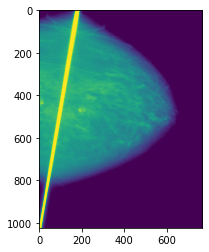

In [83]:
plt.imshow(batch[0][0][0].squeeze())

#Define the models with radiomics and bigger dataset

In [84]:
def make_model_rad_BIG_REGULIZER(shape_tensor=(4096,3072,1),feature_dim=(3,)):
    input_tensor = Input(shape=shape_tensor,name="tensor_input")
    logger.debug(f'dimensione input immagine:{shape_tensor}')
    input_vector= Input(shape=feature_dim)
    logger.debug(f'dimensione input feature:{feature_dim}')
    x = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(input_tensor)
    x = Dropout(.2,)(x)
    x = MaxPooling2D((2, 2), strides=(2,2),padding='same')(x)
    x = Conv2D(64, (3,3), strides=2,  padding='same', activation='relu')(x)
    x = Dropout(.2,)(x)
    x = Conv2D(128, (3,3), strides=2, padding='same', activation='relu',name='last_conv')(x)

    flat=Flatten()(x)
    flat=concatenate([flat,input_vector])
    den = Dense(16, activation='relu')(flat)
    #den= Dropout(.1,)(den)




    classification_output = Dense(2, activation = 'sigmoid', name="classification_output")(den)

    x = Conv2DTranspose(64, (3,3), strides=2,  padding='same', activation='relu')(x)
    x = Dropout(.2,)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(32, (3,3), strides=2, padding='same',activation='relu')(x)
    x = Conv2DTranspose(32, (3,3), strides=2, padding='same',activation='relu')(x)
    decoder_out = Conv2D(1, (5,5), padding='valid',activation='sigmoid',name="decoder_output")(x)
    model = Model([input_tensor,input_vector], [decoder_out,classification_output])
    return model

def make_model_rad_BIG(shape_tensor=(4096,3072,1),feature_dim=(3,)):
    input_tensor = Input(shape=shape_tensor,name="tensor_input")
    logger.debug(f'dimensione input immagine:{shape_tensor}')
    input_vector= Input(shape=feature_dim)
    logger.debug(f'dimensione input feature:{feature_dim}')

    x = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(input_tensor)
    #x = Dropout(.2)(x)
    x = Conv2D(64, (3,3), strides=2,  padding='same', activation='relu')(x)
    #x = Dropout(.2)(x)
    x = Conv2D(128, (3,3), strides=2, padding='same', activation='relu',name='last_conv')(x)

    flat=Flatten()(x)
    flat=concatenate([flat,input_vector])
    den = Dense(16, activation='relu')(flat)
    #den = Dropout(.2)(den)

    classification_output = Dense(2, activation = 'sigmoid', name="classification_output")(flat)

    x = Conv2DTranspose(64, (3,3), strides=2,  padding='same', activation='relu')(x)
    x = Conv2DTranspose(32, (3,3), strides=2, padding='same',activation='relu')(x)
    x = Conv2DTranspose(32, (3,3), strides=2, padding='same',activation='relu')(x)
    decoder_out = Conv2D(1,(1,1) , padding='valid',activation='sigmoid',name="decoder_output")(x)
    model = Model([input_tensor,input_vector], [decoder_out,classification_output])

    return model

def make_model_rad_BIG_UNET(shape_tensor=(4096,3072,1),feature_dim=(3,)):
    input_tensor = Input(shape=shape_tensor,name="tensor_input")
    logger.debug(f'dimensione input immagine:{shape_tensor}')
    input_vector= Input(shape=feature_dim)
    logger.debug(f'dimensione input feature:{feature_dim}')

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(input_tensor)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3),activation='relu', kernel_initializer='he_normal',
                                padding='same')(c1)
    p1 =MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
        #p2 = Resizing(32,32,interpolation='nearest')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p2)


    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
        #p3 = Resizing(16,16,interpolation='nearest')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c4)

    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p4)

    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same', name="last_conv")(c5)
    #fc layers

    flat=Flatten()(c5)
    flat=concatenate([flat,input_vector])
    den = Dense(16, activation='relu')(flat)


    classification_output = Dense(2, activation = 'sigmoid', name="classification_output")(flat)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)

        #c4 = Resizing(14,14,interpolation='nearest')(c4)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        #c3= Resizing(28,28,interpolation='nearest')(c3)

    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        #u8 = Resizing(62,62,interpolation='nearest')(c2)

    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        #c1= Resizing(112,112,interpolation='nearest')(c1)

    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c9)


    decoder_out = Conv2D(1, (1, 1), activation='sigmoid',name="decoder_output")(c9)

    model = Model([input_tensor,input_vector], [decoder_out,classification_output])
    return model

In [85]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [86]:
import tensorflow as tf
import datetime, os

In [87]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Dropout,MaxPooling2D, UpSampling2D, Dense, Flatten
from keras.models import Model, load_model
from keras.layers.experimental.preprocessing import Resizing
from keras.layers.merge import concatenate



In [88]:
import tensorflow as tf
model_rad = make_model_rad_BIG_UNET(shape_tensor=batch[0][0].shape[1:],feature_dim=batch[0][1].shape[1:]) 
model_rad.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tensor_input (InputLayer)       [(None, 1024, 768, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 768, 16 160         tensor_input[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024, 768, 16 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 768, 16 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [89]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [90]:
checkpoint_filepath = '/content/drive/MyDrive/big_weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_classification_output_auc',
    mode='max',
    save_best_only=True)

In [91]:
model_rad.compile(optimizer='adam', loss={'decoder_output':'binary_crossentropy','classification_output':'binary_crossentropy'},
                  metrics={'decoder_output':'MAE','classification_output':tf.keras.metrics.AUC()})

In [ ]:
history_rad = model_rad.fit(mass_gen_rad_big,steps_per_epoch=len(mass_gen_rad_big), epochs=epoch_number, 
                        validation_data=Validation_data,
                        callbacks=[tensorboard_callback,model_checkpoint_callback])

View on tensorboard

In [ ]:
model_rad.save('/content/drive/MyDrive/BIGUNET_try3')

In [ ]:
%tensorboard --logdir logs

View the results

In [ ]:
modelviewer(history_rad)

In [94]:
model_rad = keras.models.load_model('/content/drive/MyDrive/BIGUNET_try2')

Guardiamo un esempio di output del CAE

In [95]:
idx=1
xtrain = resize(imread(X_train_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]
ytrain = resize(imread(Y_train_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]

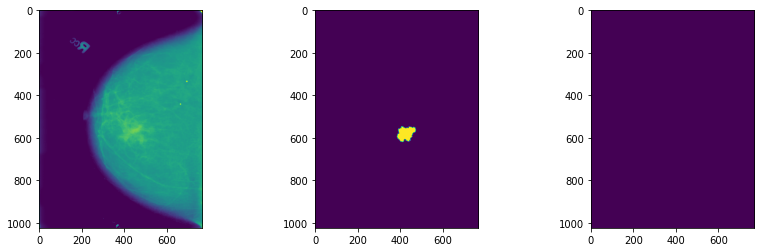

In [96]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(xtrain.squeeze())
plt.subplot(1,3,2)
plt.imshow(ytrain.squeeze())
plt.subplot(1,3,3)
plt.imshow(otsu(model_rad.predict([xtrain,feature_train_bigg[idx][np.newaxis,...]])[0].squeeze()))

Guardiamo un esempio su immagini di test

In [97]:
idx=16
xtest = resize(imread(X_test_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]
ytest = resize(imread(Y_test_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]

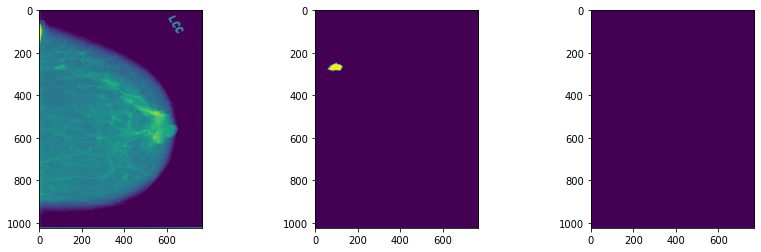

In [98]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(xtest.squeeze())
plt.subplot(1,3,2)
plt.imshow(ytest.squeeze())
plt.subplot(1,3,3)
plt.imshow(otsu(model_rad.predict([xtest,feature_test_bigg[idx][np.newaxis,...]])[0].squeeze()))

In [99]:
class_train_rad_big[idx],np.argmax(model_rad.predict([xtrain,feature_train_bigg[idx][np.newaxis,...]])[1])

(1, 0)

Calcoliamo il dice medio sul set di test e la curva roc. Per fare ciò definiamo delle versioni parallelizzabili che caricano le immagini direttamente dai path. Dato che le immagini sono grandi e principalmente l'azione è I/O, proviamo a verificare che con il multithreading si ottiene uno speed up.

Dice medio sul test

In [125]:
dices=[]
def dice_big(list_,k=1,mod=model_rad, shape=(1024,768,1) ,alpha=0.1,lists=dices):
  """calcola il dice di una singola immagine
  :type list_: lista
  :param list_: lista con il path delle immagini e l'array di feature estratte

  :type k: int
  :param k: valore massimo binarizzato della maschera

  :type mod: keras model
  :param mod: modello di keras precedentemente allenato

  :type shape: array
  :param shape: dimensione di resize dell'immagine

  :type alpha: float
  :param alpha: valore di binarizzazione

  :type lists: list
  :param lists: lista vuota da appendere

  :returns: l'indice di dice
  :rtype: float


  """
  pred=resize(imread( str(list_[0])),shape)
  pred=mod.predict([pred[np.newaxis,...],list_[1][np.newaxis,...]])[0].squeeze()>alpha
  true=resize(imread( str(list_[2])),shape).squeeze()
  intersection = np.sum(pred[true==k]) * 2.0
  try:
    dice = intersection / (np.sum(pred.squeeze()) + np.sum(true))
  except ZeroDivisionError:
    logger.exception('provato a dividere per zero!')
  logger.info(f'calcolato correttamente il dice ottenendo {dice}')
  lists.append(dice)
  return dice


In [101]:
listdicer=[]
for i in range(len(X_test_rad_big)):
  listdicer.append([X_test_rad_big[i],feature_test_bigg[i],Y_test_rad_big[i]])

In [126]:
import concurrent.futures
start=time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.map(dice_big, listdicer)
    print(future)
end=time.perf_counter()
print(f'time elapsed MT: {end-start}')

<generator object Executor.map.<locals>.result_iterator at 0x7f3016dc3a40>
time elapsed MT: 342.7602994199997


In [127]:
dices_seq=[]
start=time.perf_counter()
for i in range(len(listdicer)):
  dice_big(listdicer[i],lists=dices_seq) # gotta put in list=dices_seq
end=time.perf_counter()
print(f'time elapsed sequential: {end-start}')

time elapsed sequential: 434.7399536570001


Dunque con una piccola verifica vediamo che il MT ci da un buon speed up di circa un minuto e mezzo.

In [109]:
dices=np.array(dices)

In [110]:
meandice=dices.mean()

In [ ]:
meandice

Ora la curva roc


In [136]:
ypred=[]
def ypred_creator(list_,mod=model_rad,list_app=ypred,shape=(1024,768,1)):
  """calcola le predizioni di classificazione
  :type list_: lista
  :param list_: lista con il path delle immagini e l'array di feature estratte

  :type list_app: list
  :param list_app: lista vuota da appendere

  :type shape: array
  :param shape: dimensione di resize dell'immagine

  

  :returns: le probabilità di predizione della classificazione 
  :rtype: list


  """
  x=resize(imread( str(list_[0])),shape)
  y=mod.predict([x[np.newaxis,...],list_[1][np.newaxis,...]])[1][0]
  list_app.append(y)
  return y

In [119]:
listrocer=[]
for i in range(len(X_test_rad_big)):
  listrocer.append([X_test_rad_big[i],feature_test_bigg[i]])

In [138]:
start=time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.map(ypred_creator, listrocer)
    print(future)
end=time.perf_counter()
print(f'time elapsed MT: {end-start}')

<generator object Executor.map.<locals>.result_iterator at 0x7f301bcc65c8>
time elapsed MT: 213.47709798300093


In [135]:
ypreds_seq=[]
start=time.perf_counter()
for i in range(len(listrocer)):
  ypred_creator(listrocer[i],list_app=ypreds_seq)
end=time.perf_counter()
print(f'time elapsed sequential: {end-start}')

time elapsed sequential: 285.28195369900095


Anche qui abbiamo verificato un speed up di poco più di un minuto. Questo è senz'altro un esempio di azione di GIL.

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(class_test_rad_big, [item[0] for _, item in enumerate(ypred)], pos_label=0)

from sklearn.metrics import auc
auc = auc(fpr, tpr)

In [ ]:
plot_roc_curve(fpr, tpr,auc)


Infine vediamo una Heatmap

In [ ]:
hmap=heatmap_rad(resize(imread(X_test_rad_big[10]),(1024,768)),feature_test_bigg[10],model_rad)